In [2]:
import pandas as pd
import numpy as np
import cv2, os
import torch
import torch.nn as nn
import seaborn as sns
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from sklearn.metrics import classification_report, confusion_matrix, precision_score,recall_score,f1_score, roc_curve, roc_auc_score, matthews_corrcoef
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader
import torch_directml
import shutil
from scores import score_in_details
torch.manual_seed(240)

In [3]:
dml = torch_directml.device()

In [4]:
transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(size = (224, 224)),
        transforms.ToTensor(),
        ])

In [5]:
class MyDataset(Dataset):
    def __init__(self, ds, transform):
        self.ds = ds
        self.transform = transform
                
    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):            
        image_path = self.ds[idx][0]
        label = self.ds[idx][1]
        img = cv2.imread(image_path)
        img = self.transform(img)
            
        return {"image": img,
                "labels": label,
                "path": image_path}

In [6]:
dataset_path = "../splitted"
test_dataset = dsets.ImageFolder(root=f'{dataset_path}/test/')
test_ds = MyDataset(ds=test_dataset.imgs, transform=transform)

In [7]:
test_loader = DataLoader(test_ds, batch_size=20, drop_last=True, shuffle=False)

In [8]:
def create_model():
    model = torchvision.models.resnet152(weights='ResNet152_Weights.DEFAULT')
    n_features = model.fc.in_features
    model.fc = nn.Linear(n_features, 2)

    return model.to(dml)

base_model = create_model()

In [9]:
model_path = "../trained-models/resnet-152.pt"
base_model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')), strict=False)

<All keys matched successfully>

In [10]:
def get_predictions():
    softmax = nn.Softmax(dim=1)
    base_model.eval()
    predictions = []
    real_values = []
    pred_probas = []
    misclassified = []

    with torch.no_grad():
        for batch in tqdm(test_loader):
            inputs = batch['image'].to(dml)
            labels = batch['labels'].to(dml)
            path = batch["path"]
            
            outputs = softmax(base_model(inputs))
            
            _, preds = torch.max(outputs, dim = 1)
            for probs in outputs.cpu():   
                pred_probas.append(list(probs))
            preds = preds.cpu()
            labels = labels.cpu()
            predictions.extend(preds)
            real_values.extend(labels)
            
            for ind, (actual, pred) in enumerate(zip(labels, preds)):
                if actual != pred:
                    misclassified.append((path[ind], actual, pred))
            
    return predictions, real_values, pred_probas, misclassified

In [11]:
pred, real, probas, misclassified = get_predictions()
print(classification_report([y_actual.item() for y_actual in real], [y_pred.item() for y_pred in pred], digits=6))

  0%|          | 0/943 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0   0.953184  0.975833  0.964375      4924
           1   0.991389  0.983065  0.987210     13936

    accuracy                       0.981177     18860
   macro avg   0.972286  0.979449  0.975792     18860
weighted avg   0.981414  0.981177  0.981248     18860



Accuracy: 98.11770943796394%
Precision: 0.9814141017367914
Recall: 0.9811770943796394
F1-score: 0.9812479215585801
MCC-score: 0.9517083752123909
ROC AUC score: 0.849505829597249




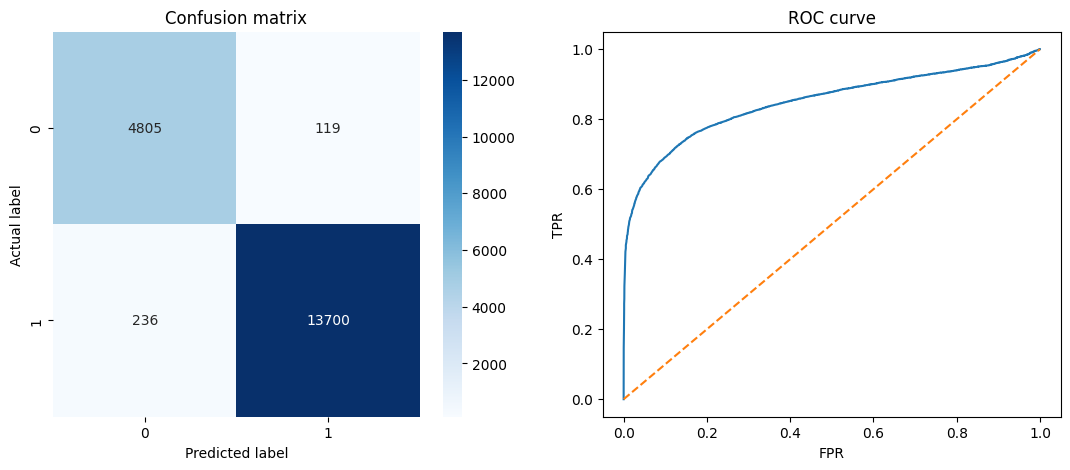

In [12]:
score_in_details(pred=pred, real=real, probas=probas)

In [31]:
dest = "../images/misclassified-new/resnet-152/"
for path, actual, pred in tqdm(misclassified):
    img_name = path.split("\\")[-1].split(".")[0]
    ext = path.split(".")[-1]
    shutil.copy(path, os.path.join(dest, f"{img_name}_{actual.item()}_{pred.item()}.{ext}"))

  0%|          | 0/355 [00:00<?, ?it/s]